In [1]:
#set parent directory as package
import sys
sys.path.append("..")

In [2]:
#set parent directory as package
import sys
from data_tools.tools import read_experiment_dic_results, merge_temporary_files, load_feather_folder_as_pd, write_dic_results
import matplotlib
import h5py
import os


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.pandas.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt


from matplotlib import rc
rc('text', usetex=True)


sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":22, 
                             "legend.fontsize":16, "xtick.labelsize":20, 
                             "ytick.labelsize":20, "legend.title_fontsize":14,  'lines.linewidth': 3, 'lines.markersize': 6})


plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
    })

In [ ]:
#First, run from the WinterKernel root folder:
#py -3 -m plotting.create_eigenvalue_comparison_file
#then use notebook to plot

df = pd.read_pickle("../data/results/df_global_to_compare_gramm_matrices_bandwidth_eigen.pkl")

In [4]:
path_to_save = f"../data/plots/global_plots/"

#### Aggregation over datasets (for mean, std, and median calculation, can be ignored)

In [5]:
def mean_array(series):
    return np.mean(np.stack(series), axis=0)
def std_array(series):
    return np.std(np.stack(series), axis=0)
def median_array(series):
    return np.median(np.stack(series), axis=0)

def ci_array_low(series):
    z_95 = 1.96  # z-score for 95% confidence interval
    z_80 = 1.282  # z-score for 80% confidence interval
    z_63 = 1.036  # z-score for 63% confidence interval
    z = z_63
    mean = np.mean(np.stack(series), axis=0)
    len_single_series = np.stack(series).shape[1]
    sem = np.std(np.stack(series), axis=0, ddof=1) / np.sqrt(len_single_series)
    return mean - z * sem

def ci_array_high(series):
    z_95 = 1.96  # z-score for 95% confidence interval
    z_80 = 1.282  # z-score for 80% confidence interval
    z_63 = 1.036  # z-score for 63% confidence interval
    z = z_63
    mean = np.mean(np.stack(series), axis=0)
    len_single_series = np.stack(series).shape[1]
    sem = np.std(np.stack(series), axis=0, ddof=1) / np.sqrt(len_single_series)
    return mean + z * sem    


#make classical_kernel_name, quantum_kernel_name, dataset_name, bandwidth, num_qubits, optimal c as string
df_short = df[["eigenvalues_quantum", "ck_quantum", "eigenvalues_classical", "ck_classical", "dataset_name",  "bandwidth_quantum", "bandwidth_classical", "quantum_kernel_name", "classical_kernel_name", "seed", "num_qubits", "optimal c_quantum", "optimal c_classical" ]].copy()

df_short["classical_kernel_name"] = df_short["classical_kernel_name"].astype("category")
df_short["quantum_kernel_name"] = df_short["quantum_kernel_name"].astype("category")
df_short["dataset_name"] = df_short["dataset_name"].astype("category")


df_short_optimal_classical = df_short[df_short["optimal c_classical"] == True]
df_short_optimal_quantum = df_short[df_short["optimal c_quantum"] == True]
df_short_not_optimal_classical = df_short[df_short["optimal c_classical"] == False]
df_short_not_optimal_quantum = df_short[df_short["optimal c_quantum"] == False]

#classical drop quantum and quantum drop classical
df_short_optimal_classical = df_short_optimal_classical.drop(columns=["eigenvalues_quantum", "ck_quantum", "bandwidth_quantum", "quantum_kernel_name", "optimal c_quantum"])
df_short_optimal_quantum = df_short_optimal_quantum.drop(columns=["eigenvalues_classical", "ck_classical", "bandwidth_classical", "classical_kernel_name", "optimal c_classical"])
df_short_not_optimal_classical = df_short_not_optimal_classical.drop(columns=["eigenvalues_quantum", "ck_quantum", "bandwidth_quantum", "quantum_kernel_name", "optimal c_quantum"])
df_short_not_optimal_quantum = df_short_not_optimal_quantum.drop(columns=["eigenvalues_classical", "ck_classical", "bandwidth_classical", "classical_kernel_name", "optimal c_classical"])


# Aggregation for optimal classical
agg_df_optimal_classical = df_short_optimal_classical.groupby(
    ["dataset_name", "num_qubits", "classical_kernel_name"]
).agg({
    "bandwidth_classical": "median",
    "eigenvalues_classical": [
        ("mean", mean_array),
        ("std", std_array),
        ("median", median_array), 
        ("ci_low", ci_array_low),
        ("ci_high", ci_array_high)
    ],
    "ck_classical": [
        ("mean", mean_array),
        ("std", std_array),
        ("median", median_array),
        ("ci_low", ci_array_low),
        ("ci_high", ci_array_high)
    ]
}).reset_index()

agg_df_optimal_classical["optimal c"] = True

# Aggregation for optimal quantum
agg_df_optimal_quantum = df_short_optimal_quantum.groupby(
    ["dataset_name", "num_qubits", "quantum_kernel_name"]
).agg({
    "bandwidth_quantum": "median",
    "eigenvalues_quantum": [
        ("mean", mean_array),
        ("std", std_array),
        ("median", median_array),
        ("ci_low", ci_array_low),
        ("ci_high", ci_array_high)
    ],
    "ck_quantum": [
        ("mean", mean_array),
        ("std", std_array),
        ("median", median_array),
        ("ci_low", ci_array_low),
        ("ci_high", ci_array_high)
    ]
}).reset_index()

agg_df_optimal_quantum["optimal c"] = True

# Aggregation for not optimal classical
agg_df_not_optimal_classical = df_short_not_optimal_classical.groupby(
    ["dataset_name", "num_qubits", "classical_kernel_name", "bandwidth_classical"]
).agg({
    "eigenvalues_classical": [
        ("mean", mean_array),
        ("std", std_array),
        ("median", median_array),
        ("ci_low", ci_array_low),
        ("ci_high", ci_array_high)
    ],
    "ck_classical": [
        ("mean", mean_array),
        ("std", std_array),
        ("median", median_array),
        ("ci_low", ci_array_low),
        ("ci_high", ci_array_high)
    ]
}).reset_index()

agg_df_not_optimal_classical["optimal c"] = False

# Aggregation for not optimal quantum
agg_df_not_optimal_quantum = df_short_not_optimal_quantum.groupby(
    ["dataset_name", "num_qubits", "quantum_kernel_name", "bandwidth_quantum"]
).agg({
    "eigenvalues_quantum": [
        ("mean", mean_array),
        ("std", std_array),
        ("median", median_array),
        ("ci_low", ci_array_low),
        ("ci_high", ci_array_high)
    ],
    "ck_quantum": [
        ("mean", mean_array),
        ("std", std_array),
        ("median", median_array),
        ("ci_low", ci_array_low),
        ("ci_high", ci_array_high)
    ]
}).reset_index()

agg_df_not_optimal_quantum["optimal c"] = False

# Flatten multi-level column indexes
def flatten_columns(df):
    df.columns = ['_'.join(col).strip('_') for col in df.columns]
    return df

agg_df_optimal_classical = flatten_columns(agg_df_optimal_classical)
agg_df_optimal_quantum = flatten_columns(agg_df_optimal_quantum)
agg_df_not_optimal_classical = flatten_columns(agg_df_not_optimal_classical)
agg_df_not_optimal_quantum = flatten_columns(agg_df_not_optimal_quantum)


# Rename columns

def rename_columns(df, kernel_name_col, bandwidth_col, eigenvalues_col, ck_col):
    return df.rename(columns={
        kernel_name_col: "kernel_type",
        bandwidth_col: "bandwidth",
        f"{eigenvalues_col}_mean": "eigenvalues_mean",
        f"{eigenvalues_col}_std": "eigenvalues_std",
        f"{eigenvalues_col}_median": "eigenvalues_median",
        f"{eigenvalues_col}_ci_low": "eigenvalues_ci_low",
        f"{eigenvalues_col}_ci_high": "eigenvalues_ci_high",
        f"{ck_col}_mean": "ck_mean",
        f"{ck_col}_std": "ck_std",
        f"{ck_col}_median": "ck_median",
        f"{ck_col}_ci_low": "ck_ci_low",
        f"{ck_col}_ci_high": "ck_ci_high",
    })

# Rename columns for each DataFrame
agg_df_optimal_classical = rename_columns(
    agg_df_optimal_classical, 
    "classical_kernel_name", 
    "bandwidth_classical", 
    "eigenvalues_classical", 
    "ck_classical"
)

agg_df_optimal_quantum = rename_columns(
    agg_df_optimal_quantum, 
    "quantum_kernel_name", 
    "bandwidth_quantum", 
    "eigenvalues_quantum", 
    "ck_quantum"
)

agg_df_not_optimal_classical = rename_columns(
    agg_df_not_optimal_classical, 
    "classical_kernel_name", 
    "bandwidth_classical", 
    "eigenvalues_classical", 
    "ck_classical"
)

agg_df_not_optimal_quantum = rename_columns(
    agg_df_not_optimal_quantum, 
    "quantum_kernel_name", 
    "bandwidth_quantum", 
    "eigenvalues_quantum", 
    "ck_quantum"
)



#concatenate all dataframes
df_agg = pd.concat([agg_df_optimal_classical, agg_df_optimal_quantum, agg_df_not_optimal_classical, agg_df_not_optimal_quantum])


C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_2228\1506954965.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_optimal_classical = df_short_optimal_classical.groupby(
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_2228\1506954965.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_optimal_quantum = df_short_optimal_quantum.groupby(
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_2228\1506954965.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

In [6]:
def kernel_to_compare_to_latex_str(kernel_to_compare):
    if kernel_to_compare.startswith("rbf_poly"):
        return "$k_{\mathrm{cl}}^{(" + kernel_to_compare[-1] + ")}$"
    elif kernel_to_compare.startswith("rbf"):
        return "$k_{\mathrm{cl}}^{(\mathrm{RBF})}$"
    else: 
        return kernel_to_compare

## Eigenvalue Fig A9 plots for plasticc (on paper), kMNIST28 (not on paper) and hidden-manifold (not on paper)

plasticc


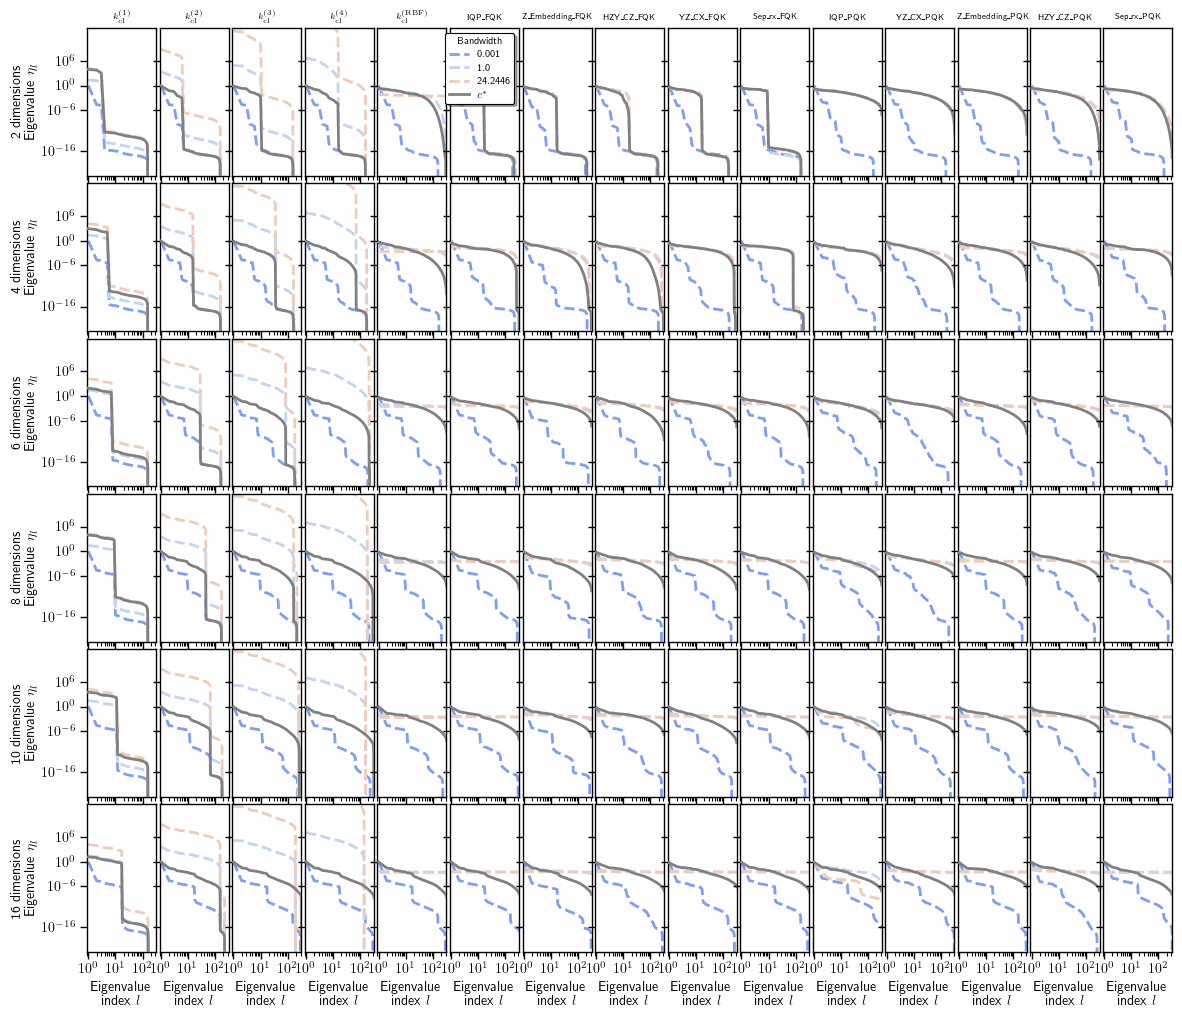

kMNIST28


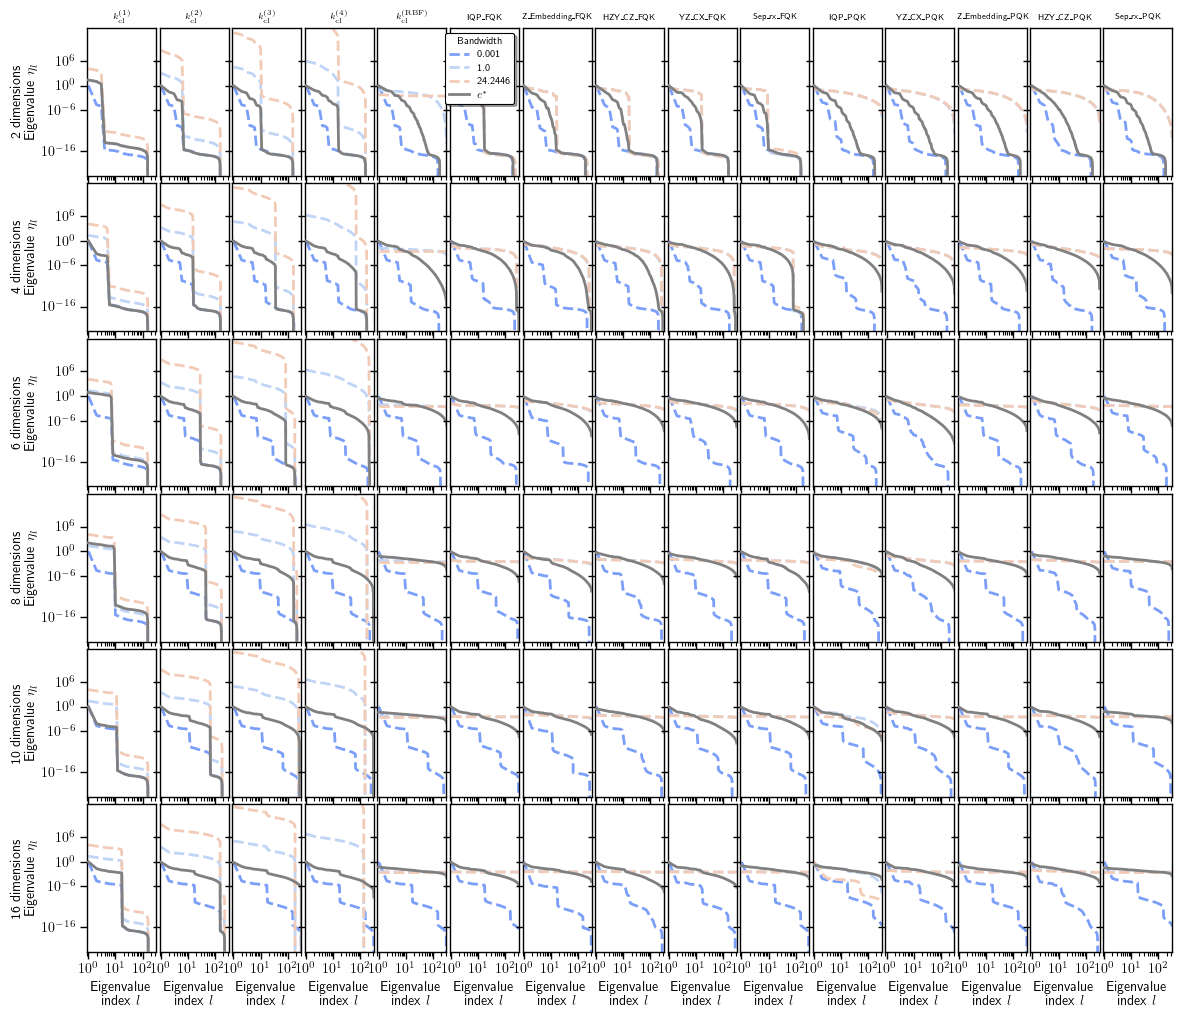

pennylane_hidden-manifold


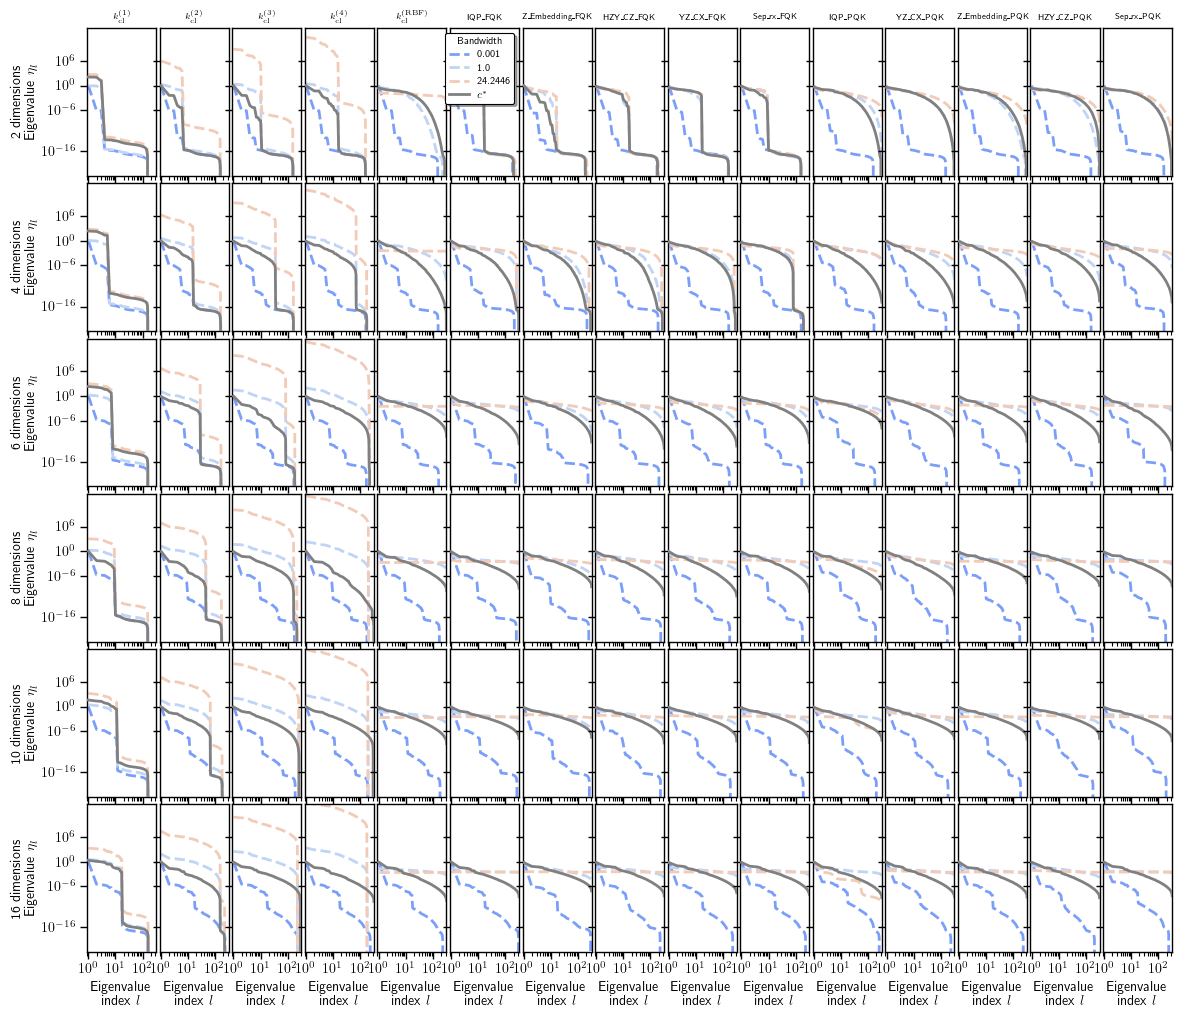

In [9]:
color_palette = sns.color_palette("coolwarm",n_colors=4)


def combination_to_plot(df_agg, dataset_name, kernel_type, num_qubits):
    df_temp = df_agg[(df_agg["dataset_name"] == dataset_name) & (df_agg["kernel_type"] == kernel_type) & (df_agg["num_qubits"] == num_qubits)]
    #sort by bandwidth
    df_temp = df_temp.sort_values(by="bandwidth", ascending=True)
    #reset index
    df_temp = df_temp.reset_index()
    return df_temp

linewidth_value = 2
#create gridspec separation, first 3 plots are closer, then last 2 are further apart
label_index_pos = (0,5)
kmnist_str = "kMNIST28"
plastic_str = "plasticc"
hiddenmaniafold_str = "pennylane_hidden-manifold"


num_qubits_to_plot = [2, 4, 6, 8, 10, 16]
dataset_name = plastic_str #replace by dataset name
#kernels to plot
method_list = ["rbf_poly_1", "rbf_poly_2", "rbf_poly_3", "rbf_poly_4", "rbf", 'IQP_FQK', "Z_Embedding_FQK", "HZY_CZ_FQK", "YZ_CX_FQK", "Sep_rx_FQK", "IQP_PQK", "YZ_CX_PQK", "Z_Embedding_PQK","HZY_CZ_PQK", "Sep_rx_PQK"]


def plot_eigenvalues_appendix(dataset_name):
        
    fig, axs = plt.subplots(len(num_qubits_to_plot), len(method_list), figsize=(14, 12), sharex=True, sharey=True, )
    for k, method in enumerate(method_list):
        for i, num_qubits in enumerate(num_qubits_to_plot):

            df_temp = combination_to_plot(df_agg, dataset_name, method, num_qubits)
            for j, row in df_temp.iterrows():

                eigenvalues = row["eigenvalues_median"]
                bandwidth = row["bandwidth"]
                x_values = np.arange(len(eigenvalues)) + 1
                if i!=label_index_pos[0] and k!=label_index_pos[1]:
                    if row["optimal c"] == False:
                        axs[i, k].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", linewidth=linewidth_value)
                    else:
                        axs[i, k].plot(x_values, eigenvalues,color="gray", linestyle="-", zorder=3, linewidth=linewidth_value)
                else:

                    if row["optimal c"] == False:
                        axs[i, k].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", label=f"{np.round(bandwidth, 4)}", linewidth=linewidth_value)
                    else:
                        #print("here")
                        axs[i, k].plot(x_values, eigenvalues, color="gray", label="$c^{*}$", linestyle="-", zorder=3, linewidth=linewidth_value)

        #add letter A, B, C, D, E
        #axs[i].text(0.05, 0.95, letters[i], transform=axs[i].transAxes, fontsize=40, fontweight='bold', va='top')
            axs[i, k].set_yscale("log")
            axs[i, k].set_xscale("log")

            axs[i, k].set_ylim([1e-22, 1e14])
            axs[i, k].set_xlim([0.9, 320])

            # Add the ylabel for the first column
            if i == 0:
                method_ = kernel_to_compare_to_latex_str(method)
                if method_.startswith("Z_Embedding"):
                    fontsize = 6
                else:
                    fontsize = 6
                axs[i, k].set_title(f"{method_}", fontsize=fontsize)

            if i == len(num_qubits_to_plot) - 1:
                axs[i, k].set_xlabel("Eigenvalue \n index $l$", fontsize=10)

            if k == 0:
                axs[i, k].set_ylabel(f"{num_qubits} dimensions \n Eigenvalue $\eta_l$", fontsize=10)

            if i == label_index_pos[0] and k == label_index_pos[1]:
                axs[i, k].legend(title="Bandwidth", loc="upper right", fontsize=7, title_fontsize=7, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor="black")
        
            #set yticks every 5 orders of magnitude
            axs[i, k].set_yticks([1e-16,  1e-6, 1e0, 1e6])
            axs[i, k].set_yticklabels(["$10^{-16}$", "$10^{-6}$", "$10^{0}$", "$10^{6}$"], fontsize=10)

            axs[i, k].set_xticks([1, 10, 100])
            axs[i, k].set_xticklabels(["$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=10)

    # Adjust the spacing between the plots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    print(dataset_name)
    plt.savefig(f"{path_to_save}all_eigenvalues_median_grid_{dataset_name}.pdf", bbox_inches='tight', dpi=500)
    plt.savefig(f"{path_to_save}all_eigenvalues_median_grid_{dataset_name}.png", bbox_inches='tight', dpi=500)
    plt.show()

plot_eigenvalues_appendix(plastic_str)
plot_eigenvalues_appendix(kmnist_str)   
plot_eigenvalues_appendix(hiddenmaniafold_str)

## Not on paper figures:

Optimal bandwidth for rbf_poly_2 is  0.05379838403443687 and num_qubits 2
Optimal bandwidth for rbf is  0.5878016072274911 and num_qubits 2
Optimal bandwidth for HZY_CZ_FQK is  0.2030917620904737 and num_qubits 2
Optimal bandwidth for rbf_poly_2 is  0.04124626382901352 and num_qubits 8
Optimal bandwidth for rbf is  0.1193776641714437 and num_qubits 8
Optimal bandwidth for HZY_CZ_FQK is  0.15570684047537317 and num_qubits 8
Optimal bandwidth for rbf_poly_2 is  0.036434520215348654 and num_qubits 16
Optimal bandwidth for rbf is  0.04124626382901352 and num_qubits 16
Optimal bandwidth for HZY_CZ_FQK is  0.1193776641714437 and num_qubits 16


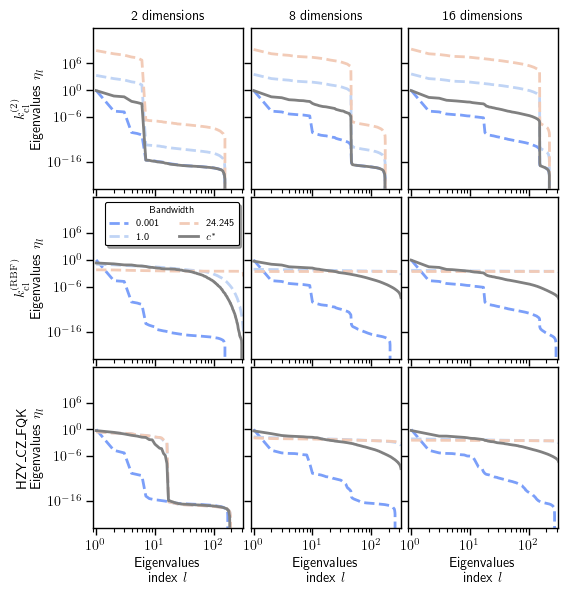

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":22, 
#                              "legend.fontsize":16, "xtick.labelsize":10, 
#                              "ytick.labelsize":10, "legend.title_fontsize":14,  'lines.linewidth': 3, 'lines.markersize': 6})

# Plot eigenvalues_median for the following combinations

color_palette = sns.color_palette("coolwarm", n_colors=4)

letters = ["A", "B", "C", "", "D", "E"]


#plotting criteria
num_qubits_to_plot = [2, 8, 16]
method_list = ["rbf_poly_2", "rbf", "HZY_CZ_FQK",]
linewidth_value = 2
label_index_pos = (1, 0)
plastic_str = "plasticc"
dataset_name = plastic_str
optimal_bandwidth_color = "gray"

def combination_to_plot(df_agg, dataset_name, kernel_type, num_qubits):
    df_temp = df_agg[(df_agg["dataset_name"] == dataset_name) & (df_agg["kernel_type"] == kernel_type) & (df_agg["num_qubits"] == num_qubits)]
    # Sort by bandwidth
    df_temp = df_temp.sort_values(by="bandwidth", ascending=True)
    # Reset index
    df_temp = df_temp.reset_index()
    return df_temp


# Create gridspec separation, first 3 plots are closer, then last 2 are further apart
fig, axs = plt.subplots(len(method_list), len(num_qubits_to_plot), figsize=(6, 6.5), sharex=True, sharey=True)

for i, num_qubits in enumerate(num_qubits_to_plot):
    for k, method in enumerate(method_list):
        df_temp = combination_to_plot(df_agg, dataset_name, method, num_qubits)
        if "FQK" in method or "PQK" in method:
            df_temp.loc[df_temp["optimal c"] == True, "bandwidth"] = df_temp.loc[df_temp["optimal c"] == True, "bandwidth_quantum_median"].values[0]        
        else:
            df_temp.loc[df_temp["optimal c"] == True, "bandwidth"] = df_temp.loc[df_temp["optimal c"] == True, "bandwidth_classical_median"].values[0]        
        #df_temp.sort_values(by="bandwidth", inplace=True)
        #df_temp = df_temp.reset_index(drop=True)
        print(f"Optimal bandwidth for {method} is  {df_temp.loc[df_temp['optimal c'] == True, 'bandwidth'].values[0]} and num_qubits {num_qubits}")

        for j, row in df_temp.iterrows():
            eigenvalues = row["eigenvalues_median"]
            eigenvalues_std = row["eigenvalues_std"]
            bandwidth = row["bandwidth"]
            x_values = np.arange(len(eigenvalues)) + 1
            if k != label_index_pos[0] and i != label_index_pos[1]:
                if row["optimal c"] == False:
                    axs[k, i].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", linewidth=linewidth_value)
                    #plot eigenvalues_std
                else:
                    axs[k, i].plot(x_values, eigenvalues, color=optimal_bandwidth_color, linestyle="-", zorder=3, linewidth=linewidth_value)
            else:
                if row["optimal c"] == False:
                    axs[k, i].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", label=f"{np.round(bandwidth, 3)}", linewidth=linewidth_value)
                else:
                    axs[k, i].plot(x_values, eigenvalues, color=optimal_bandwidth_color, label="$c^{*}$", linestyle="-", zorder=3, linewidth=linewidth_value)
        axs[k, i].set_yscale("log")
        axs[k, i].set_xscale("log")

        axs[k, i].set_ylim([1e-22, 1e14])
        axs[k, i].set_xlim([0.9, 320])

        # Add the title for the first row
        if k == 0:
            axs[k, i].set_title(f"{num_qubits} dimensions", fontsize=10)

        if k == len(method_list) - 1:
            axs[k, i].set_xlabel("Eigenvalues \n index $l$", fontsize=10)

        method = kernel_to_compare_to_latex_str(method)
        if i == 0:
            axs[k, i].set_ylabel(f"{method} \n Eigenvalues $\eta_l$", fontsize=10)

        if k == label_index_pos[0] and i == label_index_pos[1]:
            axs[k, i].legend(title="Bandwidth", loc="upper right", fontsize=7, title_fontsize=7, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor="black", ncols=2)

        # Set yticks every 5 orders of magnitude
        axs[k, i].set_yticks([1e-16, 1e-6, 1e0, 1e6])
        axs[k, i].set_yticklabels(["$10^{-16}$", "$10^{-6}$", "$10^{0}$", "$10^{6}$"], fontsize=10)

        axs[k, i].set_xticks([1, 10, 100])
        axs[k, i].set_xticklabels(["$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=10)

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig(f"{path_to_save}eigenvalues_median_grid_{dataset_name}.pdf", bbox_inches='tight', dpi=500)
plt.savefig(f"{path_to_save}eigenvalues_median_grid_{dataset_name}.png", bbox_inches='tight', dpi=500)

plt.show()

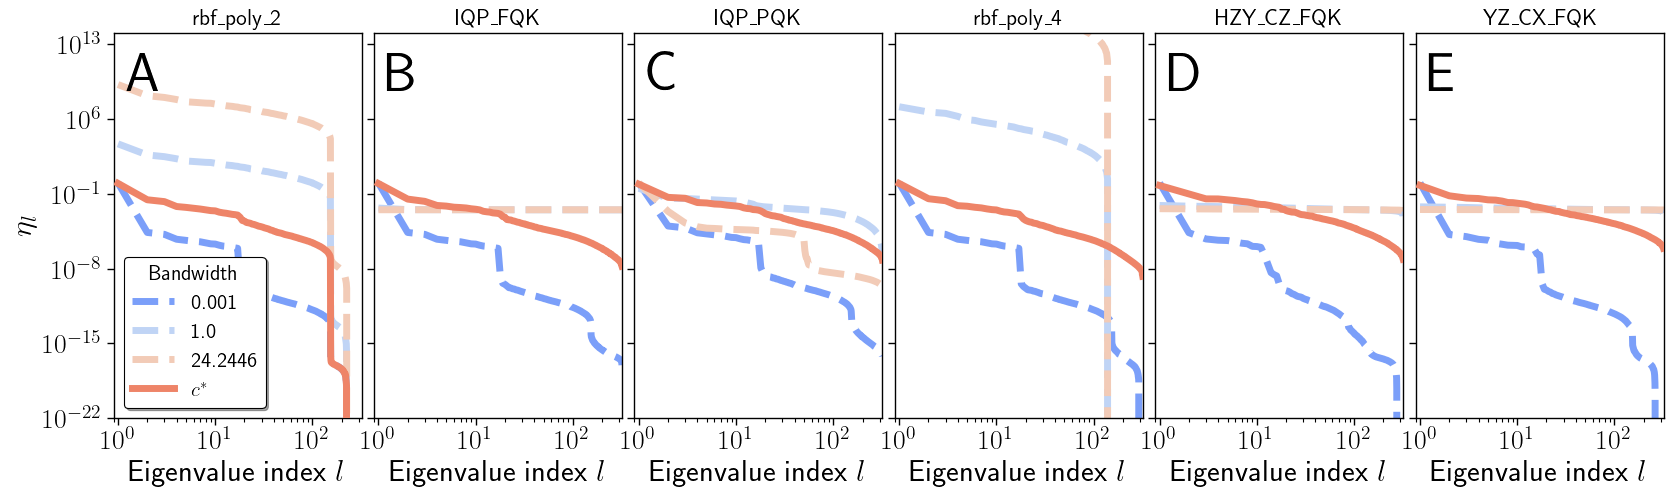

In [11]:
#plot eigenvalues_median for the following combinations 

kMNIST_str = "kMNIST28".encode()
plasticc_str = "plasticc"


list_of_combinations = [{"dataset_name": plasticc_str, "kernel_type": "rbf_poly_2", "num_qubits": 16},
                        {"dataset_name": plasticc_str, "kernel_type": "IQP_FQK", "num_qubits": 16},
                        {"dataset_name": plasticc_str, "kernel_type": "IQP_PQK", "num_qubits": 16},
                        {"dataset_name": plasticc_str, "kernel_type": "rbf_poly_4", "num_qubits": 16},
                        {"dataset_name": plasticc_str, "kernel_type": "HZY_CZ_FQK", "num_qubits": 16},
                        {"dataset_name": plasticc_str, "kernel_type": "YZ_CX_FQK", "num_qubits": 16},
                        ]
#
color_palette = sns.color_palette("coolwarm",n_colors=4)

letters = ["A", "B", "C", "", "D", "E"]

linewidth_value = 5
#create gridspec separation, first 3 plots are closer, then last 2 are further apart
fig, axs = plt.subplots(1, len(list_of_combinations), figsize=(20, 5), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1]})
for i, combination in enumerate(list_of_combinations):
    df_temp = combination_to_plot(df_agg, combination["dataset_name"], combination["kernel_type"], combination["num_qubits"])
    for j, row in df_temp.iterrows():
        eigenvalues = row["eigenvalues_median"]
        bandwidth = row["bandwidth"]
        x_values = np.arange(len(eigenvalues)) + 1
        if i!=0:
            if row["optimal c"] == False:
                axs[i].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", linewidth=linewidth_value)
                
                if i == 1:
                    pass
                    #print(bandwidth)
            else:
                axs[i].plot(x_values, eigenvalues,color=color_palette[j], linestyle="-", zorder=10, linewidth=linewidth_value)
        else:
            if row["optimal c"] == False:
                axs[i].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", label=f"{np.round(bandwidth, 4)}", linewidth=linewidth_value)
            else:
                #print("here")
                axs[i].plot(x_values, eigenvalues, color=color_palette[j], label="$c^{*}$", linestyle="-", zorder=10, linewidth=linewidth_value)

    #add letter A, B, C, D, E
    axs[i].text(0.05, 0.95, letters[i], transform=axs[i].transAxes, fontsize=40, fontweight='bold', va='top')
    axs[i].set_yscale("log")
    axs[i].set_xscale("log")

    axs[i].set_ylim([1e-22, 1e14])
    axs[i].set_xlim([0.9, 320])

    # Set the title for each subplot
    axs[i].set_title(combination["kernel_type"])

    # Add the ylabel for the first column
    if i == 0:
        axs[i].set_ylabel("$\eta_{l}$")
        #make beautiful legend with beautiful box
        axs[i].legend(title="Bandwidth", loc="best", fontsize=15, title_fontsize=15, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor="black")
        #include yticks 10**-20, 10**-10, 10**0, 10**10, 10**20


    # Add the xlabel for all columns
    axs[i].set_xlabel("Eigenvalue index $l$")
    
    #set yticks
    #axs[i].set_yticks([

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.05)


#plt.savefig(f"{path_to_save}eigenvalues_median.pdf", bbox_inches='tight', dpi=500)


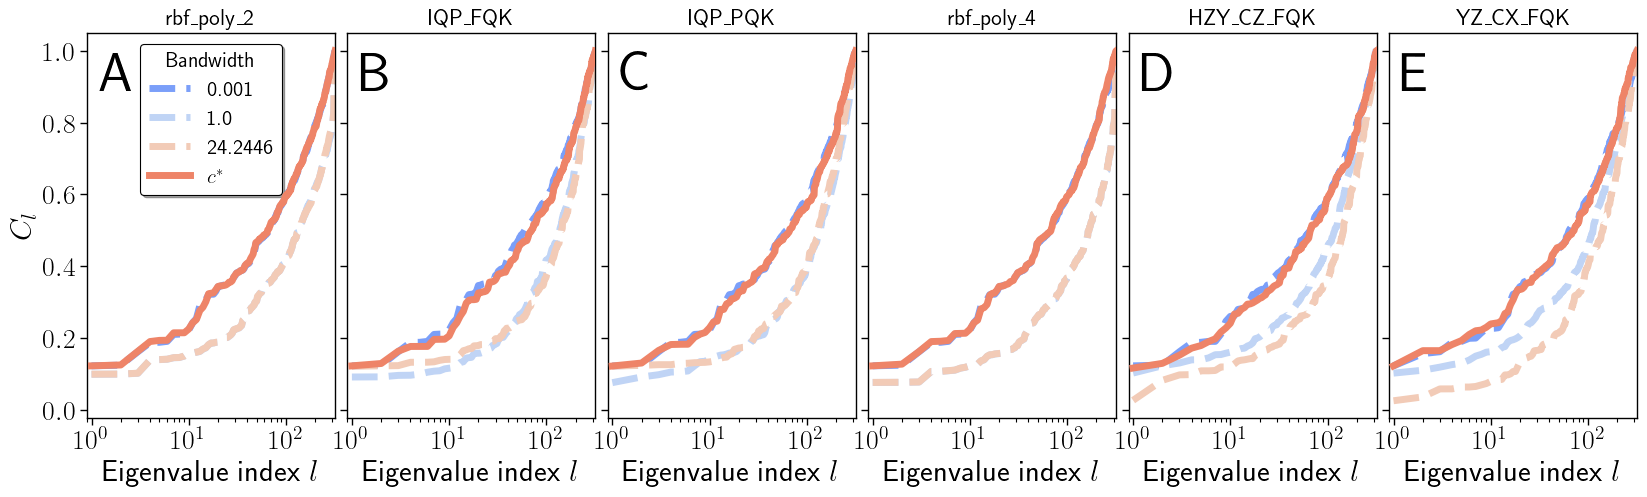

In [12]:
#plot eigenvalues_median for the following combinations 
#
color_palette = sns.color_palette("coolwarm",n_colors=4)

letters = ["A", "B", "C", "", "D", "E"]

linewidth_value = 5
#create gridspec separation, first 3 plots are closer, then last 2 are further apart
fig, axs = plt.subplots(1, len(list_of_combinations), figsize=(20, 5), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1]})
for i, combination in enumerate(list_of_combinations):
    df_temp = combination_to_plot(df_agg, combination["dataset_name"], combination["kernel_type"], combination["num_qubits"])
    if combination["dataset_name"] == "kMNIST28".encode():
        i += 1
    for j, row in df_temp.iterrows():
        eigenvalues = row["ck_median"]
        bandwidth = row["bandwidth"]
        x_values = np.arange(len(eigenvalues)) + 1
        if i!=0:
            if row["optimal c"] == False:
                axs[i].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", linewidth=linewidth_value)
                
                if i == 1:
                    pass
                    #print(bandwidth)
            else:
                axs[i].plot(x_values, eigenvalues,color=color_palette[j], linestyle="-", zorder=10, linewidth=linewidth_value)
        else:
            if row["optimal c"] == False:
                axs[i].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", label=f"{np.round(bandwidth, 4)}", linewidth=linewidth_value)
            else:
                #print("here")
                axs[i].plot(x_values, eigenvalues, color=color_palette[j], label="$c^{*}$", linestyle="-", zorder=10, linewidth=linewidth_value)

    #add letter A, B, C, D, E
    axs[i].text(0.05, 0.95, letters[i], transform=axs[i].transAxes, fontsize=40, fontweight='bold', va='top')
    #axs[i].set_yscale("log")
    axs[i].set_xscale("log")

    #axs[i].set_ylim([1e-22, 1e14])
    axs[i].set_xlim([0.9, 320])

    # Set the title for each subplot
    axs[i].set_title(combination["kernel_type"])

    # Add the ylabel for the first column
    if i == 0:
        axs[i].set_ylabel("$C_{l}$")
        #make beautiful legend with beautiful box
        axs[i].legend(title="Bandwidth", loc="best", fontsize=15, title_fontsize=15, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor="black")
        #include yticks 10**-20, 10**-10, 10**0, 10**10, 10**20


    # Add the xlabel for all columns
    axs[i].set_xlabel("Eigenvalue index $l$")
    
    #set yticks
    #axs[i].set_yticks([

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.05)




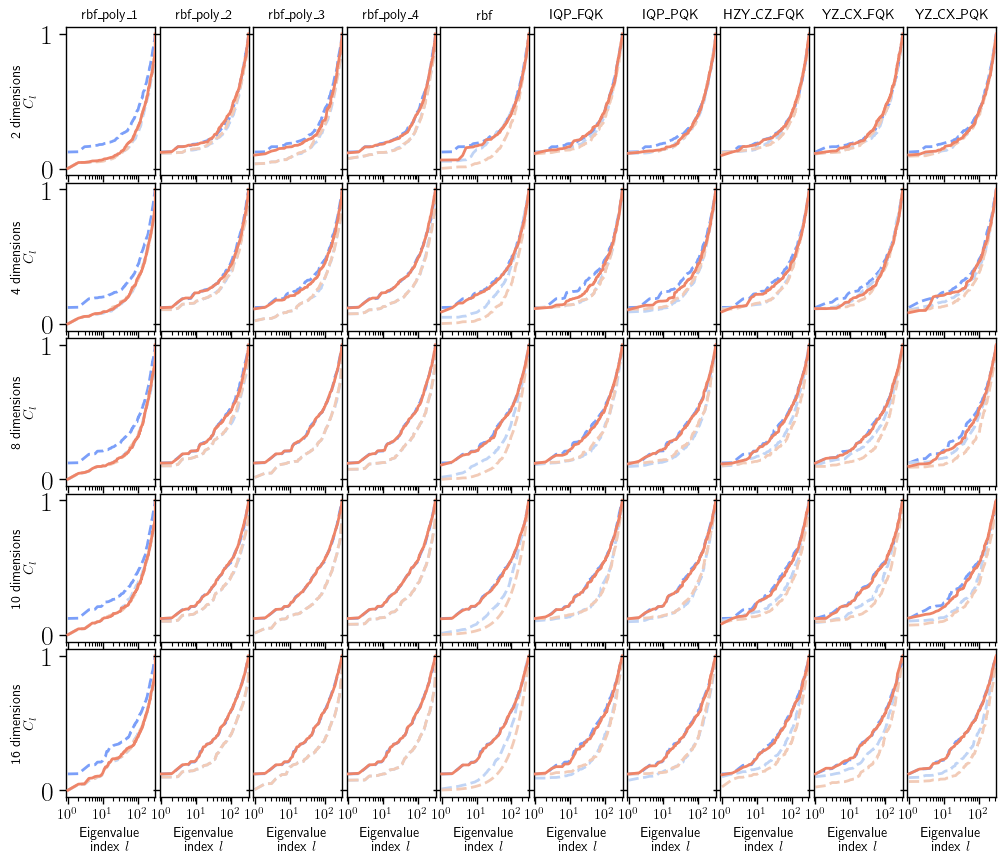

In [13]:

# sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":22, 
#                              "legend.fontsize":16, "xtick.labelsize":10, 
#     
color_palette = sns.color_palette("coolwarm",n_colors=4)

letters = ["A", "B", "C", "", "D", "E"]

num_qubits_to_plot = [2, 4, 8, 10, 16]

method_list = ["rbf_poly_1", "rbf_poly_2", "rbf_poly_3", "rbf_poly_4", "rbf", 'IQP_FQK', "IQP_PQK", "HZY_CZ_FQK", "YZ_CX_FQK", "YZ_CX_PQK"]


linewidth_value = 2
#create gridspec separation, first 3 plots are closer, then last 2 are further apart

fig, axs = plt.subplots(len(num_qubits_to_plot), len(method_list),  figsize=(12, 10), sharex=True, sharey=True, )
for k, method in enumerate(method_list):
    for i, num_qubits in enumerate(num_qubits_to_plot):

        df_temp = combination_to_plot(df_agg, dataset_name, method, num_qubits)
        for j, row in df_temp.iterrows():

            eigenvalues = row["ck_median"]
            bandwidth = row["bandwidth"]
            x_values = np.arange(len(eigenvalues)) + 1
            if i!=0 and k!=0:
                if row["optimal c"] == False:
                    axs[i, k].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", linewidth=linewidth_value)
                else:
                    axs[i, k].plot(x_values, eigenvalues,color=color_palette[j], linestyle="-", zorder=3, linewidth=linewidth_value)
            else:
                if row["optimal c"] == False:
                    axs[i, k].plot(x_values, eigenvalues, color=color_palette[j], linestyle="--", label=f"{np.round(bandwidth, 4)}", linewidth=linewidth_value)
                else:
                    #print("here")
                    axs[i, k].plot(x_values, eigenvalues, color=color_palette[j], label="$c^{*}$", linestyle="-", zorder=3, linewidth=linewidth_value)

    #add letter A, B, C, D, E
    #axs[i].text(0.05, 0.95, letters[i], transform=axs[i].transAxes, fontsize=40, fontweight='bold', va='top')
        #axs[i, k].set_yscale("log")
        axs[i, k].set_xscale("log")

        axs[i, k].set_xlim([0.9, 320])

        # Add the ylabel for the first column
        if i == 0:
            axs[i, k].set_title(f"{method}", fontsize=10)

        if i == len(num_qubits_to_plot) - 1:
            axs[i, k].set_xlabel("Eigenvalue \n index $l$", fontsize=10)

        if k == 0:
            axs[i, k].set_ylabel(f"{num_qubits} dimensions \n  $C_l$", fontsize=10)

        if i == len(method_list) - 1 and k == 0:
            axs[i, k].legend(title="Bandwidth", loc="upper right", fontsize=10, title_fontsize=10, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor="black")
    
        #set yticks every 5 orders of magnitude
        #axs[i, k].set_yticks([1e-16,  1e-6, 1e0, 1e6])
        #axs[i, k].set_yticklabels(["$10^{-16}$", "$10^{-6}$", "$10^{0}$", "$10^{6}$"], fontsize=10)

        axs[i, k].set_xticks([1, 10, 100])
        axs[i, k].set_xticklabels(["$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=10)

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.05, hspace=0.05)


